### Cat and Dog dataset training notebook
Purpose of this notebook is to show end to end machine learning workflow
1. Use label dataset created by Sagemaker GroundTruth. Then split the dataset into train and validation. 
2. Train the model using Sagemaker training container, 
3. Deploy the model using Sagemaker endpont
4. Lastly do model inference


Block below shows how to use GroundTruth labled dataset, then split data into training and validation
### IMP: Plese change "BUCKET =" to you your S3 bucket

In [1]:
import json
import numpy as np
import boto3
import sagemaker

BUCKET = 'catandogsmalldataset'
EXP_NAME = 'catanddog-smalldataset-ml-lab' # Any valid S3 prefix.

role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name
s3 = boto3.client('s3')
bucket_region = s3.head_bucket(Bucket=BUCKET)['ResponseMetadata']['HTTPHeaders']['x-amz-bucket-region']
assert bucket_region == region, "You S3 bucket {} and this notebook need to be in the same region.".format(BUCKET)

OUTPUT_MANIFEST = 's3://catandogsmalldataset/output/catanddog-malldataset/manifests/output/output.manifest'

!aws s3 cp {OUTPUT_MANIFEST} 'output.manifest'

with open('output.manifest', 'r') as f:
    output = [json.loads(line) for line in f.readlines()]

# Shuffle output in place.
np.random.shuffle(output)
    
dataset_size = len(output)
train_test_split_index = round(dataset_size*0.8)

train_data = output[:train_test_split_index]
validation_data = output[train_test_split_index:]

num_training_samples = 0
with open('mllab.train.manifest', 'w') as f:
    for line in train_data:
        f.write(json.dumps(line))
        f.write('\n')
        num_training_samples += 1
    
with open('mllab.validation.manifest', 'w') as f:
    for line in validation_data:
        f.write(json.dumps(line))
        f.write('\n')

download: s3://catandogsmalldataset/output/catanddog-malldataset/manifests/output/output.manifest to ./output.manifest


#### Upload training and validation dataset to S3 bucket, so that this dataset can be used by Sagemaker Training jobs later


In [2]:

s3.upload_file('train.manifest',BUCKET, EXP_NAME + '/mllab.train.manifest')
s3.upload_file('validation.manifest',BUCKET, EXP_NAME + '/mllab.validation.manifest')



### Create Sagemaker training job. Change hyperparamerter per training needs

In [3]:
# Create unique job name 
import os
import json
import random
import time
import imageio
import numpy as np
import boto3
import sagemaker
from urllib.parse import urlparse


nn_job_name_prefix = 'groundtruth-augmented-manifest-demo'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
nn_job_name = nn_job_name_prefix + timestamp

training_image = sagemaker.amazon.amazon_estimator.get_image_uri(boto3.Session().region_name, 'image-classification', repo_version='latest')

training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "Pipe"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output/'.format(BUCKET, EXP_NAME)
    },
    "ResourceConfig": {
        "InstanceCount": 1,   
        "InstanceType": "ml.p3.16xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": nn_job_name,
    "HyperParameters": {
        "epochs": "30",
        "image_shape": "3,224,224",
        "learning_rate": "0.01",
        "lr_scheduler_step": "10,20",
        "mini_batch_size": "32",
        "num_classes": "2",
        "num_layers": "18",
        "num_training_samples": str(num_training_samples),
        "resize": "224",
        "use_pretrained_model": "1"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 86400
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, 'mllab.train.manifest'),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref","category"]
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "AugmentedManifestFile",
                    "S3Uri": 's3://{}/{}/{}'.format(BUCKET, EXP_NAME, 'mllab.validation.manifest'),
                    "S3DataDistributionType": "FullyReplicated",
                    "AttributeNames": ["source-ref","category"]
                }
            },
            "ContentType": "application/x-recordio",
            "RecordWrapperType": "RecordIO",
            "CompressionType": "None"
        }
    ]
}

### Now we will create the SageMaker training job.

In [4]:
sagemaker_client = boto3.client('sagemaker')
sagemaker_client.create_training_job(**training_params)

# Confirm that the training job has started
print('Transform job started')
while(True):
    status = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)['TrainingJobStatus']
    if status == 'Completed':
        print("Transform job ended with status: " + status)
        break
    if status == 'Failed':
        message = response['FailureReason']
        print('Transform failed with the following error: {}'.format(message))
        raise Exception('Transform job failed') 
    time.sleep(30)

Transform job started
Transform job ended with status: Completed


## Deploy the Model
Now that we've fully labeled our dataset and have a trained model, we want to use the model to perform inference.

This section involves several steps,

Create Model - Create model for the training output
Host the model for realtime inference - Create an inference endpoint and perform realtime inference.

In [5]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
model_name="groundtruth-demo-mllab-cat-dog-model" + timestamp
print(model_name)
info = sagemaker_client.describe_training_job(TrainingJobName=nn_job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

primary_container = {
    'Image': training_image,
    'ModelDataUrl': model_data,
}

create_model_response = sagemaker_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

groundtruth-demo-mllab-cat-dog-model-2019-04-11-07-33-32
s3://catandogsmalldataset/catanddog-smalldataset-ml-lab/output/groundtruth-augmented-manifest-demo-2019-04-11-07-23-41/output/model.tar.gz
arn:aws:sagemaker:us-east-1:460151482535:model/groundtruth-demo-mllab-cat-dog-model-2019-04-11-07-33-32


## Realtime Inference
We now host the model with an endpoint and perform realtime inference.

Create endpoint configuration - Create a configuration defining an endpoint.
Create endpoint - Use the configuration to create an inference endpoint.
Perform inference - Perform inference on some input data using the endpoint.
Clean up - Delete the endpoint and model


In [6]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = 'mllab-ground-truth-demo-' + str(int(time.time()))

endpoint_config_name = job_name + '-epc' + timestamp
endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: mllab-ground-truth-demo-1554968021-epc-2019-04-11-07-33-41
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:460151482535:endpoint-config/mllab-ground-truth-demo-1554968021-epc-2019-04-11-07-33-41


## Create Endpoint
Lastly, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes about 10 minutes to complete.

In [7]:
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
endpoint_name = job_name + '-ep' + timestamp
print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': endpoint_name,
    'EndpointConfigName': endpoint_config_name,
}
endpoint_response = sagemaker_client.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))

# get the status of the endpoint
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))

# wait until the status has changed
sagemaker_client.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

# print the status of the endpoint
endpoint_response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

Endpoint name: mllab-ground-truth-demo-1554968021-ep-2019-04-11-07-33-45
EndpointArn = arn:aws:sagemaker:us-east-1:460151482535:endpoint/mllab-ground-truth-demo-1554968021-ep-2019-04-11-07-33-45
EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


## Test endpoint

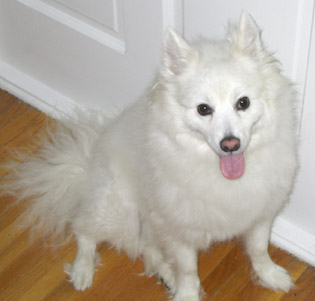

In [8]:
#file_name = 'image.jpg'
file_name = '187.jpg'
# test image
from IPython.display import Image
Image(file_name) 

In [11]:
import json
import numpy as np
import boto3
runtime = boto3.Session().client(service_name='runtime.sagemaker') 
#endpoint_name = "mllab-ground-truth-demo-1554968021-ep-2019-04-11-07-33-45"
with open(file_name, 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload)
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['cat', 'dog']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - dog, probability - 0.9962630867958069
